# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link:
https://colab.research.google.com/drive/1XK2tbd8os9mhXQE0GaO0r2b7zQksZCTz?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

### Answer
I have split the dataset randomly into 70:15:15 ratio for training, validation and test sets. This has been done using the torchvision.datasets.ImageFolder function (to load the dataset) and random_split (to split the datasets). This ratio enables us to obtain a large portion of the data for training while also retaining susbtantial data for testing and validation.
Thus, all 2219 images have been split into 1553 training images, 332 validation images and 334 test images.

In [ ]:
#Importing the libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Unzip the data and store it in folder Lab3
import os
os.chdir('/content/gdrive/MyDrive')
!unzip -q Lab3.zip -d Lab3

In [ ]:
def get_loaders(data_dir, batch_size=64):
  transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  dataset = torchvision.datasets.ImageFolder(
    root=data_dir, transform=transformations)

  train_len = int(0.7 * len(dataset))
  val_len = int(0.15 * len(dataset))
  test_len = len(dataset)-train_len-val_len

  train, val, test = torch.utils.data.random_split(dataset, [train_len, val_len, test_len])

  train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

  return dataset, train_loader, val_loader, test_loader, train_len, val_len, test_len

In [ ]:
data_dir = '/content/gdrive/MyDrive/Lab3/Lab3_Gestures_Summer'

In [ ]:
dataset, train_loader, val_loader, test_loader, train_len, val_len, test_len = get_loaders(data_dir)

In [ ]:
print('Total = ', len(dataset))
print('Train = ', train_len)
print('Validation = ', val_len)
print('Test = ', test_len)

Total =  2219
Train =  1553
Validation =  332
Test =  334


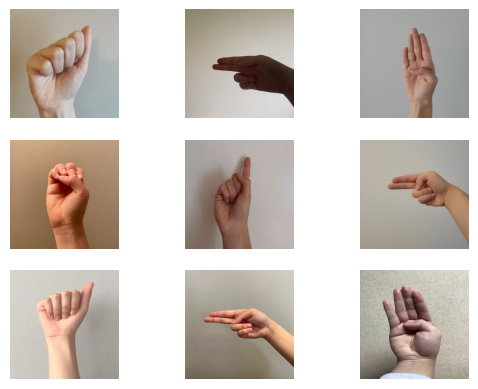

In [ ]:
#Plotting random signs in the train dataset
import matplotlib.pyplot as plt

k = 0
for i, data in enumerate(train_loader):
  inputs, label = data
  image = inputs[0]
  img = np.transpose(image, [1,2,0])
  img = img/2 + 0.5
  plt.subplot(3, 3, k + 1)
  plt.axis('off')
  plt.imshow(img)
  k = k + 1
  if k>8:
    break

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

I have used a version of LeNet in this model. It contains 2 convolutional layers, 2 max pooling layers, and 3 linear (fully connected) layers, which may have dropouts for tuning. The convolutional layers extract spatial features from the images and the fully connected layers act as the linear classifier.

###1st convolutional layer:
Input channels = 3 \
Output Channels = 6 \
Kernel Size = 5 \
Stride = 1 \
Padding = 2 \
ReLU Activation used \
Followed by 2x2 max pooling kernel with a stride of 2

###2nd convolutional layer:
Input channels = 6 \
Output Channels = 16 \
Kernel Size = 5 \
Stride = 1 \
Padding = 0 \
ReLU Activation used \
Following by 2x2 max pooling kernel with a stride of 2

###Flatten Layer:
Flatten layer to feed the input to a linear classifier

###Fully Connected Layer 1:
No of inputs = 16 * 54 * 54 \
No of outputs = 120 \
ReLU Activation Used with dropouts (if needed)

###Fully Connected Layer 2:
No of inputs = 120 \
No of outputs = 84 \
ReLU Activation Used with dropouts (if needed)

###Fully Connected Layer 3:
No of inputs = 84
No of outputs = 9 (No of classes)

In [ ]:
class LeNet(nn.Module):
  def __init__(self, p=0.0):
    super(LeNet, self).__init__()
    self.name = "LeNet"
    self.conv1 = nn.Conv2d(3, 6, 5, 1, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.linear1 = nn.Linear(16*54*54, 120)
    self.linear2 = nn.Linear(120, 84)
    self.linear3 = nn.Linear(84, 9)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.dropout = nn.Dropout(p=0.0)

  def forward(self, x):
    x = F.relu(self.pool(self.conv1(x)))
    x = F.relu(self.pool(self.conv2(x)))
    x = x.view(-1, 16*54*54)
    x = self.dropout(F.relu(self.linear1(x)))
    x = self.dropout(F.relu(self.linear2(x)))
    x = self.linear3(x)
    return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
#Helper Functions

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         acc: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_acc = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        outputs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, dim=1)
        corr = (predicted == labels).sum().item()
        total_acc += corr
        total_loss += loss.item()
        total_epoch += len(labels)
    acc = float(total_acc) / total_epoch
    loss = float(total_loss) / (i + 1)
    return acc, loss

In [ ]:
model = LeNet()

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=20):
  target_classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]

  torch.manual_seed(1000)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

  train_acc = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)

  start_time = time.time()

  for epoch in range(num_epochs):
      total_train_loss = 0.0
      total_train_acc = 0.0
      total_epoch = 0
      for i, data in enumerate(train_loader, 0):
          # Get the inputs
          inputs, labels = data
          # print(labels)
          # Zero the parameter gradients
          optimizer.zero_grad()
          # Forward pass, backward pass, and optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          outputs = F.softmax(outputs, dim=1)
          _, predicted = torch.max(outputs, dim=1)
          # print(predicted)
          # print(outputs)

          # Calculate the statistics
          corr = (predicted == labels).sum().item()
          # print(corr)
          total_train_acc += corr
          total_train_loss += loss.item()
          total_epoch += len(labels)
      train_acc[epoch] = float(total_train_acc) / total_epoch
      train_loss[epoch] = float(total_train_loss) / (i+1)
      val_acc[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
      print(("Epoch {}: Train Acc: {}, Train loss: {} |"+
              "Validation Acc: {}, Validation loss: {}").format(
                  epoch + 1,
                  train_acc[epoch],
                  train_loss[epoch],
                  val_acc[epoch],
                  val_loss[epoch]))
     # Save the current model (checkpoint) to a file
      model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
      torch.save(net.state_dict(), model_path)
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
  # Write the train/test loss/err into CSV file for plotting later
  epochs = np.arange(1, num_epochs + 1)
  np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_acc)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
train_net(model)

Epoch 1: Train Acc: 0.1390856406954282, Train loss: 2.195717763900757 |Validation Acc: 0.20783132530120482, Validation loss: 2.18589985370636
Epoch 2: Train Acc: 0.27945911139729557, Train loss: 2.0905529737472532 |Validation Acc: 0.33433734939759036, Validation loss: 1.797550876935323
Epoch 3: Train Acc: 0.44430135222150674, Train loss: 1.51344566822052 |Validation Acc: 0.5180722891566265, Validation loss: 1.346777617931366
Epoch 4: Train Acc: 0.6155827430779137, Train loss: 1.1049942421913146 |Validation Acc: 0.572289156626506, Validation loss: 1.1957560578982036
Epoch 5: Train Acc: 0.631680618158403, Train loss: 1.0180836629867553 |Validation Acc: 0.6566265060240963, Validation loss: 1.0135245025157928
Epoch 6: Train Acc: 0.6696716033483581, Train loss: 0.9367409300804138 |Validation Acc: 0.7078313253012049, Validation loss: 0.8278021911780039
Epoch 7: Train Acc: 0.7559562137797811, Train loss: 0.6677468657493592 |Validation Acc: 0.7650602409638554, Validation loss: 0.70780325929323

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

I took the random 150 samples on the train dataset and trained it with a learning rate of 0.01 and batch size of 64, like the same way as the previous one. It achieved a training accuracy of 100% in 35 epochs as seen in the code run below.

In [ ]:
from torch.utils.data import Subset
import random

dataset = train_loader.dataset

samples = 150
#indices = range(0, samples)
indices = random.sample(range((len(dataset))), samples)
small_dataset = Subset(dataset, indices)
small_loader = torch.utils.data.DataLoader(small_dataset, batch_size=64, shuffle=True)

In [ ]:
model = LeNet()

In [ ]:
target_classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]

num_epochs = 45
torch.manual_seed(1000)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_acc = np.zeros(num_epochs)
train_loss = np.zeros(num_epochs)

start_time = time.time()

for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_train_acc = 0.0
    total_epoch = 0
    for i, data in enumerate(small_loader, 0):
        # Get the inputs
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass, backward pass, and optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        outputs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, dim=1)

        # Calculate the statistics
        corr = (predicted == labels).sum().item()
        # print(corr)
        total_train_acc += corr
        total_train_loss += loss.item()
        total_epoch += len(labels)
    train_acc[epoch] = float(total_train_acc) / total_epoch
    train_loss[epoch] = float(total_train_loss) / (i+1)
    print(("Epoch {}: Train Acc: {}, Train loss: {}").format(
                epoch + 1,
                train_acc[epoch],
                train_loss[epoch]))
    # Save the current model (checkpoint) to a file
    # model_path = get_model_name(model.name, 64, 0.01, epoch)
    # torch.save(model.state_dict(), model_path)
print('Finished Training')
end_time = time.time()
elapsed_time = end_time - start_time
print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
# Write the train loss/acc into CSV file for plotting later
# epochs = np.arange(1, num_epochs + 1)
# np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
# np.savetxt("{}_train_loss.csv".format(model_path), train_loss)

Epoch 1: Train Acc: 0.1, Train loss: 2.2072516282399497
Epoch 2: Train Acc: 0.12, Train loss: 2.199158032735189
Epoch 3: Train Acc: 0.21333333333333335, Train loss: 2.1912941137949624
Epoch 4: Train Acc: 0.20666666666666667, Train loss: 2.1813510258992515
Epoch 5: Train Acc: 0.21333333333333335, Train loss: 2.1817723910013833
Epoch 6: Train Acc: 0.2, Train loss: 2.168604771296183
Epoch 7: Train Acc: 0.15333333333333332, Train loss: 2.146430412928263
Epoch 8: Train Acc: 0.26, Train loss: 2.117520252863566
Epoch 9: Train Acc: 0.26, Train loss: 2.094148794809977
Epoch 10: Train Acc: 0.26666666666666666, Train loss: 2.017605781555176
Epoch 11: Train Acc: 0.37333333333333335, Train loss: 1.9316718975702922
Epoch 12: Train Acc: 0.4666666666666667, Train loss: 1.679735541343689
Epoch 13: Train Acc: 0.5266666666666666, Train loss: 1.395455042521159
Epoch 14: Train Acc: 0.5733333333333334, Train loss: 1.2164698441823323
Epoch 15: Train Acc: 0.41333333333333333, Train loss: 1.8722885449727376
Ep

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

Three hyperparameters worth tuning are:

1. Batch Size
2. Learning Rate
3. No of linear layers

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [ ]:
dataset, train_loader, val_loader, test_loader, train_len, val_len, test_len = get_loaders(data_dir, batch_size=128)

In [ ]:
model_1 = LeNet()
train_net(model_1, batch_size=128, learning_rate=0.01, num_epochs=30)

Epoch 1: Train Acc: 0.11461687057308435, Train loss: 2.197520897938655 |Validation Acc: 0.11746987951807229, Validation loss: 2.1981666882832847
Epoch 2: Train Acc: 0.13071474565357372, Train loss: 2.193839293259841 |Validation Acc: 0.13855421686746988, Validation loss: 2.1948396364847818
Epoch 3: Train Acc: 0.1442369607211848, Train loss: 2.185227008966299 |Validation Acc: 0.19879518072289157, Validation loss: 2.1811402638753257
Epoch 4: Train Acc: 0.22086284610431423, Train loss: 2.1327964525956373 |Validation Acc: 0.17771084337349397, Validation loss: 2.0804479916890464
Epoch 5: Train Acc: 0.31809401159047007, Train loss: 1.8682435292464037 |Validation Acc: 0.24096385542168675, Validation loss: 2.404743512471517
Epoch 6: Train Acc: 0.3509336767546684, Train loss: 1.8405494689941406 |Validation Acc: 0.44879518072289154, Validation loss: 1.5737061103185017
Epoch 7: Train Acc: 0.4983902124919511, Train loss: 1.4402489295372596 |Validation Acc: 0.47289156626506024, Validation loss: 1.31

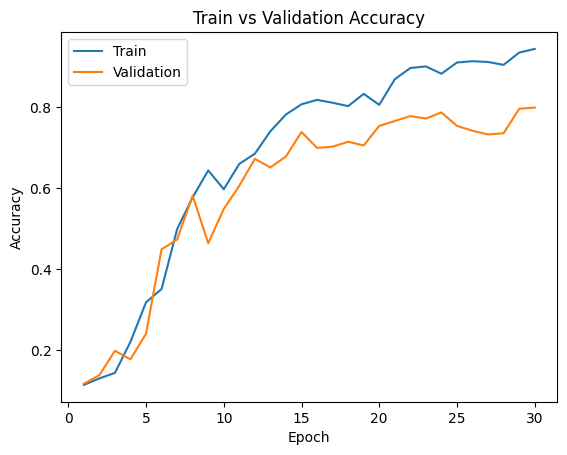

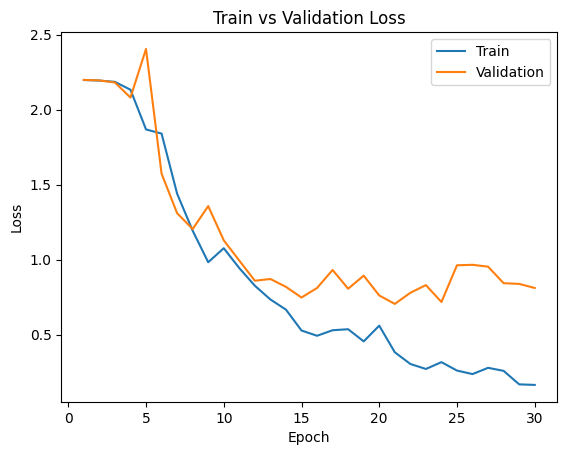

In [ ]:
plot_training_curve(get_model_name("LeNet", batch_size=128, learning_rate=0.01, epoch=30-1))

In [ ]:
dataset, train_loader, val_loader, test_loader, train_len, val_len, test_len = get_loaders(data_dir, batch_size=256)

In [ ]:
model_2 = LeNet()
train_net(model_2, batch_size=256, learning_rate=0.02, num_epochs=30)

Epoch 1: Train Acc: 0.11976819059884096, Train loss: 2.196202346256801 |Validation Acc: 0.1144578313253012, Validation loss: 2.18937349319458
Epoch 2: Train Acc: 0.128783000643915, Train loss: 2.1888248920440674 |Validation Acc: 0.14759036144578314, Validation loss: 2.1732592582702637
Epoch 3: Train Acc: 0.2652929813264649, Train loss: 2.149857657296317 |Validation Acc: 0.2469879518072289, Validation loss: 2.08123242855072
Epoch 4: Train Acc: 0.29555698647778494, Train loss: 1.9114760501044137 |Validation Acc: 0.3192771084337349, Validation loss: 1.7995161414146423
Epoch 5: Train Acc: 0.41661300708306503, Train loss: 1.5423674242837089 |Validation Acc: 0.39457831325301207, Validation loss: 1.7925384044647217
Epoch 6: Train Acc: 0.459111397295557, Train loss: 1.5921123708997453 |Validation Acc: 0.4759036144578313, Validation loss: 1.4507043361663818
Epoch 7: Train Acc: 0.5338055376690277, Train loss: 1.3008408376148768 |Validation Acc: 0.4427710843373494, Validation loss: 1.500184893608

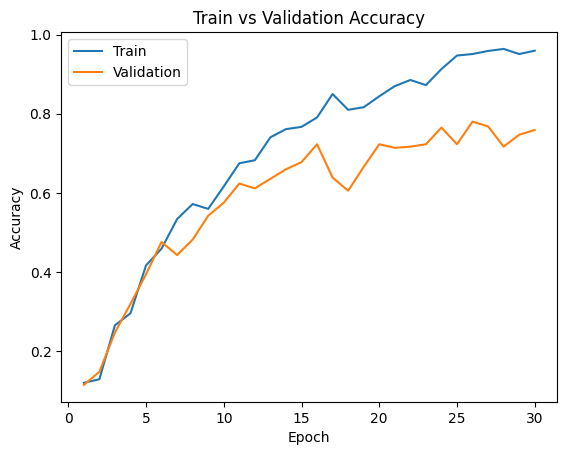

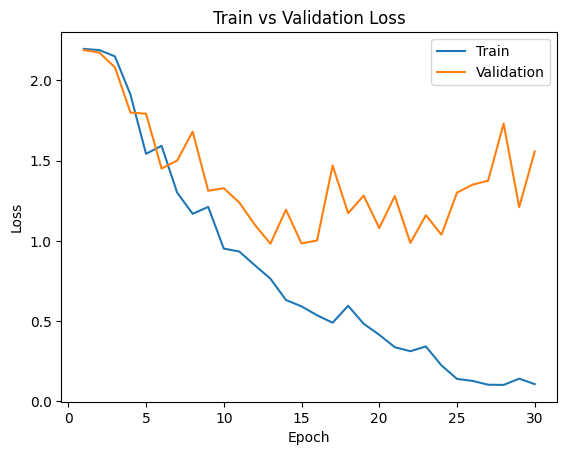

In [ ]:
plot_training_curve(get_model_name("LeNet", batch_size=256, learning_rate=0.02, epoch=30-1))

In [ ]:
dataset, train_loader, val_loader, test_loader, train_len, val_len, test_len = get_loaders(data_dir, batch_size=50)

In [ ]:
model_3 = LeNet()
train_net(model_3, batch_size=50, learning_rate=0.007, num_epochs=30)

Epoch 1: Train Acc: 0.1320025756600129, Train loss: 2.1898996829986572 |Validation Acc: 0.21385542168674698, Validation loss: 2.1604626178741455
Epoch 2: Train Acc: 0.2755956213779781, Train loss: 1.92491852119565 |Validation Acc: 0.47289156626506024, Validation loss: 1.508564761706761
Epoch 3: Train Acc: 0.5138441725692209, Train loss: 1.3348117172718048 |Validation Acc: 0.5421686746987951, Validation loss: 1.3162133182798113
Epoch 4: Train Acc: 0.6188023180940115, Train loss: 1.0318821417167783 |Validation Acc: 0.5993975903614458, Validation loss: 1.1791690928595406
Epoch 5: Train Acc: 0.708950418544752, Train loss: 0.8216236410662532 |Validation Acc: 0.6024096385542169, Validation loss: 1.0510119710649763
Epoch 6: Train Acc: 0.7495170637475853, Train loss: 0.6852256748825312 |Validation Acc: 0.6475903614457831, Validation loss: 1.0752276352473669
Epoch 7: Train Acc: 0.759175788795879, Train loss: 0.6577905006706715 |Validation Acc: 0.6024096385542169, Validation loss: 1.359639040061

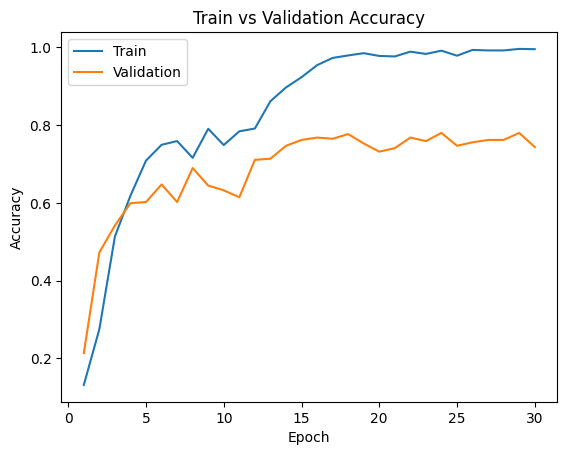

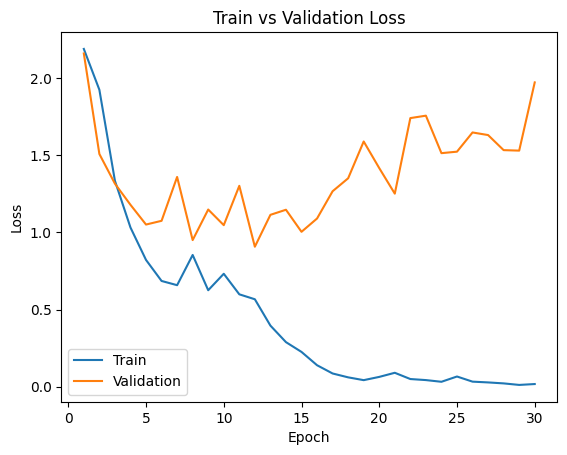

In [ ]:
plot_training_curve(get_model_name("LeNet", batch_size=50, learning_rate=0.007, epoch=30-1))

In [ ]:
dataset, train_loader, val_loader, test_loader, train_len, val_len, test_len = get_loaders(data_dir, batch_size=50)

In [ ]:
class LeNetMoreLayers(nn.Module):
  def __init__(self, p=0.2):
    super(LeNetMoreLayers, self).__init__()
    self.name = "LeNetMoreLayers"
    self.conv1 = nn.Conv2d(3, 6, 5, 1, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.linear1 = nn.Linear(16*54*54, 120)
    self.linear2 = nn.Linear(120, 84)
    self.linear3 = nn.Linear(84, 32)
    self.linear4 = nn.Linear(32, 9)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    x = F.relu(self.pool(self.conv1(x)))
    x = F.relu(self.pool(self.conv2(x)))
    x = x.view(-1, 16*54*54)
    x = self.dropout(F.relu(self.linear1(x)))
    x = self.dropout(F.relu(self.linear2(x)))
    x = self.dropout(F.relu(self.linear3(x)))
    x = self.linear4(x)
    return x

In [ ]:
model_3 = LeNetMoreLayers()
train_net(model_3, batch_size=50, learning_rate=0.007, num_epochs=25)

Epoch 1: Train Acc: 0.11332904056664521, Train loss: 2.1980336979031563 |Validation Acc: 0.12650602409638553, Validation loss: 2.197221006665911
Epoch 2: Train Acc: 0.1313586606567933, Train loss: 2.1939272210001945 |Validation Acc: 0.15060240963855423, Validation loss: 2.1921039649418423
Epoch 3: Train Acc: 0.1622665808113329, Train loss: 2.1676835119724274 |Validation Acc: 0.14759036144578314, Validation loss: 2.143181017466954
Epoch 4: Train Acc: 0.24533161622665808, Train loss: 1.9591212570667267 |Validation Acc: 0.28313253012048195, Validation loss: 1.8667100667953491
Epoch 5: Train Acc: 0.37475853187379266, Train loss: 1.6692951545119286 |Validation Acc: 0.3493975903614458, Validation loss: 1.771551592009408
Epoch 6: Train Acc: 0.437862202189311, Train loss: 1.5170507282018661 |Validation Acc: 0.4246987951807229, Validation loss: 1.7112753220966883
Epoch 7: Train Acc: 0.4855119124275596, Train loss: 1.3440030552446842 |Validation Acc: 0.39759036144578314, Validation loss: 1.64196

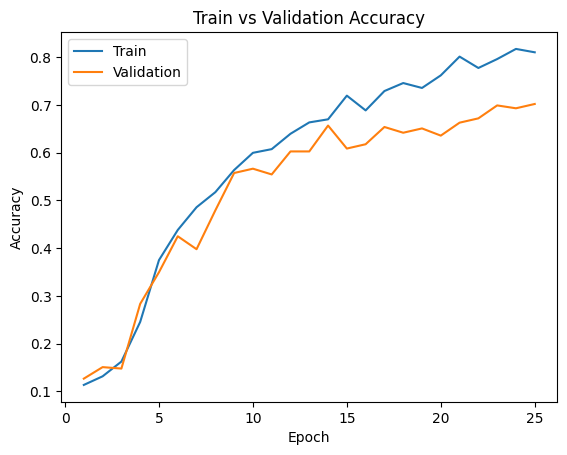

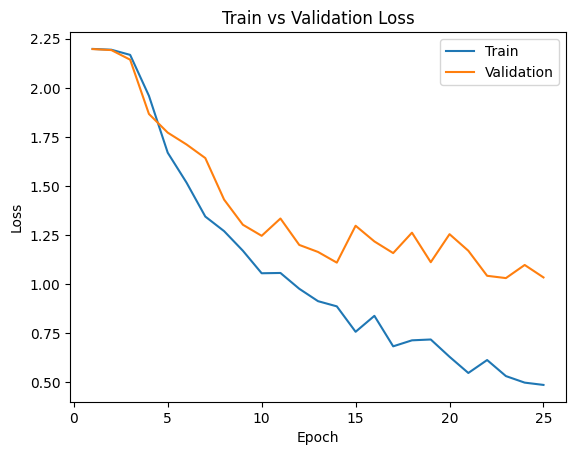

In [ ]:
plot_training_curve(get_model_name("LeNetMoreLayers", batch_size=50, learning_rate=0.007, epoch=25-1))

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

### Answer

Model 1 is the best model. The training/validation loss decreases and the accuracy increases consistently to give it the best set of results, clearly showcasing that the model was able to generalize patterns in the data effectively.

Model 2 does not reach the convergence for the loss function. This is due to the large batch size and high learning rate explaining the fluctuations and is not the best model as it does not achieve optimal training results

Model 3 suffers from overfitting. This can be clearly seen from the training accuracy which almost reaches 100% but the validation loss after decreasing, starts to increas, indicating that the model has overfit the training data.

Model 4 shows that the dropout layers affected the training making the loss and error decrease more consistently. However, it's clear that more epochs will be needed to better fit the data and so the training isn't complete.

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
acc, loss = evaluate(model_1, test_loader, criterion=nn.CrossEntropyLoss())

In [ ]:
print('Test Accuracy = ', acc)

Test Accuracy =  0.9281437125748503


In [ ]:
print('Test Loss = ', loss)

Test Loss =  0.3230615556240082


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 89.6MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
dataset, train_loader, val_loader, test_loader, train_len, val_len, test_len = get_loaders(data_dir, batch_size=64)

In [ ]:
#Saves the features into tensor using numpy
def savefeatures(loader, type):
  features_all = []
  labels_all = []
  loader_iter = iter(loader)
  for images, labels in loader_iter:
    features_all.append(alexnet.features(images).detach().numpy())
    labels_all.append(labels)
  features_all = torch.FloatTensor(np.concatenate((features_all)))
  labels_all = (torch.Tensor(np.concatenate(labels_all))).long()
  torch.save((features_all, labels_all), f'{type}_features.pt')

savefeatures(train_loader, 'train')
savefeatures(val_loader, 'validation')
savefeatures(test_loader, 'test')

In [ ]:
#Loads the features and saves them into tensor datasets and then loaders using DataLoader
# and TensorDataset in torch.utils.data
train_features, train_labels = torch.load('train_features.pt')
valid_features, valid_labels = torch.load('validation_features.pt')
test_features, test_labels = torch.load('test_features.pt')

train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
valid_dataset = torch.utils.data.TensorDataset(valid_features, valid_labels)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)

In [ ]:
train_loader_alex = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_alex = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader_alex = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

#### Answer
Built a simple linear classifier to classify the features extracted from the alexnet pretrained weights into different language signs. Consists of Flattening layer and 3 fully connected layers with inputs of (256 * 6 * 6, 128, 64) to give outputs of (128, 64, 9) with ReLU Activation functions.


In [ ]:
class SmallNet(nn.Module):
  def __init__(self):
    self.name = "SmallNet"
    super(SmallNet, self).__init__()
    self.linear1 = nn.Linear(256 * 6 * 6, 128)
    self.linear2 = nn.Linear(128, 64)
    self.linear3 = nn.Linear(64, 9)

  def forward(self, x):
    x = x.view(-1, 256*6*6)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x

In [ ]:
small_model = SmallNet()

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
target_classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]

torch.manual_seed(1000)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(small_model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 20

train_acc = np.zeros(num_epochs)
train_loss = np.zeros(num_epochs)
val_acc = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)

start_time = time.time()

for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_train_acc = 0.0
    total_epoch = 0
    for i, data in enumerate(train_loader_alex, 0):
        # Get the inputs
        inputs, labels = data
        # print(labels)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass, backward pass, and optimize
        outputs = small_model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        outputs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, dim=1)
        # print(predicted)
        # print(outputs)

        # Calculate the statistics
        corr = (predicted == labels).sum().item()
        # print(corr)
        total_train_acc += corr
        total_train_loss += loss.item()
        total_epoch += len(labels)
    train_acc[epoch] = float(total_train_acc) / total_epoch
    train_loss[epoch] = float(total_train_loss) / (i+1)
    val_acc[epoch], val_loss[epoch] = evaluate(small_model, val_loader_alex, criterion)
    print(("Epoch {}: Train Acc: {}, Train loss: {} |"+
            "Validation Acc: {}, Validation loss: {}").format(
                epoch + 1,
                train_acc[epoch],
                train_loss[epoch],
                val_acc[epoch],
                val_loss[epoch]))
    # Save the current model (checkpoint) to a file
    model_path = get_model_name(small_model.name, 64, 0.01, epoch)
    torch.save(small_model.state_dict(), model_path)
print('Finished Training')
end_time = time.time()
elapsed_time = end_time - start_time
print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
# Write the train/test loss/err into CSV file for plotting later
epochs = np.arange(1, num_epochs + 1)
np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
np.savetxt("{}_val_err.csv".format(model_path), val_acc)
np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

Epoch 1: Train Acc: 0.5550547327752736, Train loss: 1.3654006266593932 |Validation Acc: 0.6596385542168675, Validation loss: 0.8738260169823965
Epoch 2: Train Acc: 0.8293625241468127, Train loss: 0.4869139838218689 |Validation Acc: 0.8795180722891566, Validation loss: 0.3181561691065629
Epoch 3: Train Acc: 0.9253058596265293, Train loss: 0.2098400726914406 |Validation Acc: 0.8734939759036144, Validation loss: 0.3441393847266833
Epoch 4: Train Acc: 0.9471989697359948, Train loss: 0.14634856581687927 |Validation Acc: 0.8313253012048193, Validation loss: 0.3905010869105657
Epoch 5: Train Acc: 0.9665164198325821, Train loss: 0.10917597763240337 |Validation Acc: 0.9036144578313253, Validation loss: 0.24939494704206785
Epoch 6: Train Acc: 0.9896973599484868, Train loss: 0.05132628533989191 |Validation Acc: 0.9216867469879518, Validation loss: 0.18659820190320411
Epoch 7: Train Acc: 0.9948486799742434, Train loss: 0.02502516394481063 |Validation Acc: 0.927710843373494, Validation loss: 0.2434

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

I got 93.41% test accuracy on my AlexNet Transfer Learning model compared with around 92.8% accuracy on the model without transfer learning, thus both are extremely similar.

In [ ]:
evaluate(small_model, test_loader_alex, nn.CrossEntropyLoss())

(0.9341317365269461, 0.35395680864651996)